### 1. Loading the Datasets
Training: Code Red 559 10 Min + Nimda 559 10 Min 

Test: Slammer 559 10 Min

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Import explainability libraries if installed
try:
    import shap
    import lime
    import lime.lime_tabular
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP and/or LIME libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap lime' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
# Load the first training dataset - update the path to the dataset file you want to use
dataset_path = "../datasets/ratios/dataset_nimda_559_10_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1056, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,268,17,0,113,0,3,0.0,0,0.824615,...,0.721649,0.0,0.278351,0.197761,0.414062,0.175385,2001-09-15 20:13:25,1000584805,6,57
1,1,526,16,0,227,0,0,0.0,0,0.728532,...,0.876923,0.0,0.123077,0.062738,0.578947,0.271468,2001-09-15 20:23:25,1000585405,6,196
2,2,167,14,0,72,0,0,0.0,0,0.878947,...,0.879518,0.0,0.120482,0.317365,0.449153,0.121053,2001-09-15 20:33:25,1000586005,5,23
3,3,76,14,0,44,0,1,0.0,0,0.791667,...,0.924528,0.0,0.075472,0.223684,0.531250,0.208333,2001-09-15 20:43:25,1000586605,3,20
4,4,212,15,0,151,0,0,0.0,0,0.883333,...,0.886792,0.0,0.113208,0.150943,0.470588,0.116667,2001-09-15 20:53:25,1000587205,6,28


In [5]:
# Load the second training dataset - update the path to the dataset file you want to use
dataset_path = "../datasets/ratios/dataset_code-red_559_10_rrc04.csv"
df_2 = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df_2.shape}")
df_2.head()

Dataset shape: (736, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,352,17,0,191,0,18,0.000000,0,0.860636,...,0.733766,0.0,0.266234,0.446023,0.713636,0.139364,2001-07-17 00:50:50,995331050,4,57
1,1,355,12,0,129,0,0,0.000000,0,0.857488,...,0.894737,0.0,0.105263,0.098592,0.368421,0.142512,2001-07-17 01:00:50,995331650,4,59
2,2,397,11,0,168,11,4,0.104762,4,0.918981,...,0.744000,0.0,0.256000,0.095718,0.413043,0.081019,2001-07-17 01:10:50,995332250,4,35
3,3,274,10,0,100,31,0,0.113139,3,0.861635,...,0.760563,0.0,0.239437,0.186131,0.432203,0.138365,2001-07-17 01:20:50,995332850,4,44
4,4,419,11,0,187,26,1,0.062053,4,0.912854,...,0.789474,0.0,0.210526,0.389021,0.493939,0.087146,2001-07-17 01:30:50,995333450,4,40


In [6]:
# Combine the training data
df = pd.concat([df, df_2])
print(f"Dataset shape: {df.shape}")

Dataset shape: (1792, 31)


### 2. Data Exploration and Preprocessing

In [7]:
# Check basic statistics
df.describe()

,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_news,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp2,unique_as_path_avg,withdrawals
count,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,...,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1.792000e+03,1792.000000,1792.000000
mean,461.477679,397.242746,14.075335,0.223772,216.325335,8.220424,1.845424,0.016058,1.010045,0.815625,...,0.022596,0.826414,0.001164,0.172422,0.240443,0.498346,0.184375,9.987039e+08,5.526786,109.157366
std,281.573737,1053.563389,3.052018,0.416888,986.442723,63.965434,5.018235,0.021759,0.872631,0.090632,...,0.063934,0.082656,0.005514,0.082510,0.090851,0.117750,0.090632,2.637644e+06,1.414355,933.290083
min,0.000000,8.000000,7.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.041366,...,0.000000,0.305556,0.000000,0.000000,0.003948,0.061420,0.002208,9.953310e+08,1.000000,1.000000
25%,223.750000,156.000000,12.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.772703,...,0.000000,0.778743,0.000000,0.114895,0.178717,0.442660,0.122807,9.955997e+08,5.000000,30.000000
50%,447.500000,260.000000,14.000000,0.000000,126.000000,2.000000,1.000000,0.008460,1.000000,0.824655,...,0.006410,0.834867,0.000000,0.164121,0.237124,0.491596,0.175345,1.000681e+09,6.000000,52.000000
75%,671.250000,420.250000,16.000000,0.000000,207.000000,7.000000,2.000000,0.023440,2.000000,0.877193,...,0.019231,0.884615,0.000000,0.220372,0.295023,0.542094,0.227297,1.000949e+09,6.000000,98.000000
max,1032.000000,27607.000000,31.000000,1.000000,26740.000000,2003.000000,92.000000,0.184615,7.000000,0.997792,...,0.948575,1.000000,0.082192,0.694444,0.710191,1.000000,0.958634,1.001204e+09,13.000000,35850.000000


In [8]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0            0
announcements         0
as_path_max           0
class                 0
nlri_ann              0
number_rare_ases      0
origin_changes        0
rare_ases_avg         0
rare_ases_max         0
ratio_ann             0
ratio_dups            0
ratio_exp_wd          0
ratio_flaps           0
ratio_imp_wd          0
ratio_imp_wd2         0
ratio_imp_wd_dpath    0
ratio_imp_wd_spath    0
ratio_longer          0
ratio_longer2         0
ratio_nadas           0
ratio_news            0
ratio_origin0         0
ratio_origin1         0
ratio_origin2         0
ratio_shorter         0
ratio_shorter2        0
ratio_wd              0
timestamp             0
timestamp2            0
unique_as_path_avg    0
withdrawals           0
dtype: int64

In [9]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    1391
1     401
Name: count, dtype: int64


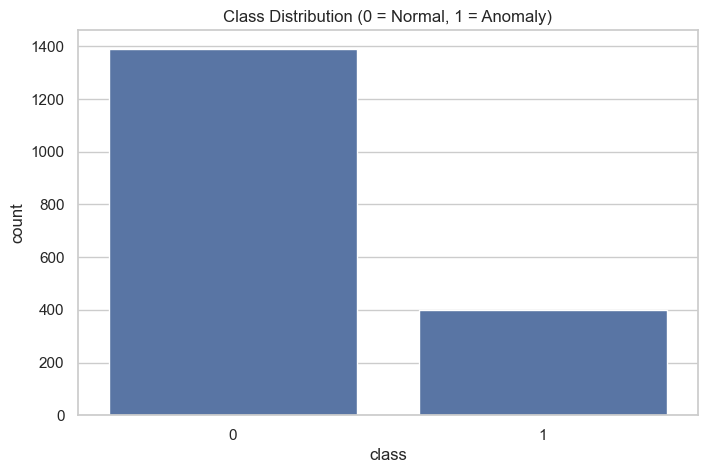

In [10]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [11]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 27
Feature names:


['announcements',
 'as_path_max',
 'nlri_ann',
 'number_rare_ases',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'ratio_ann',
 'ratio_dups',
 'ratio_exp_wd',
 'ratio_flaps',
 'ratio_imp_wd',
 'ratio_imp_wd2',
 'ratio_imp_wd_dpath',
 'ratio_imp_wd_spath',
 'ratio_longer',
 'ratio_longer2',
 'ratio_nadas',
 'ratio_news',
 'ratio_origin0',
 'ratio_origin1',
 'ratio_origin2',
 'ratio_shorter',
 'ratio_shorter2',
 'ratio_wd',
 'unique_as_path_avg',
 'withdrawals']

### 3. Feature Analysis and Selection

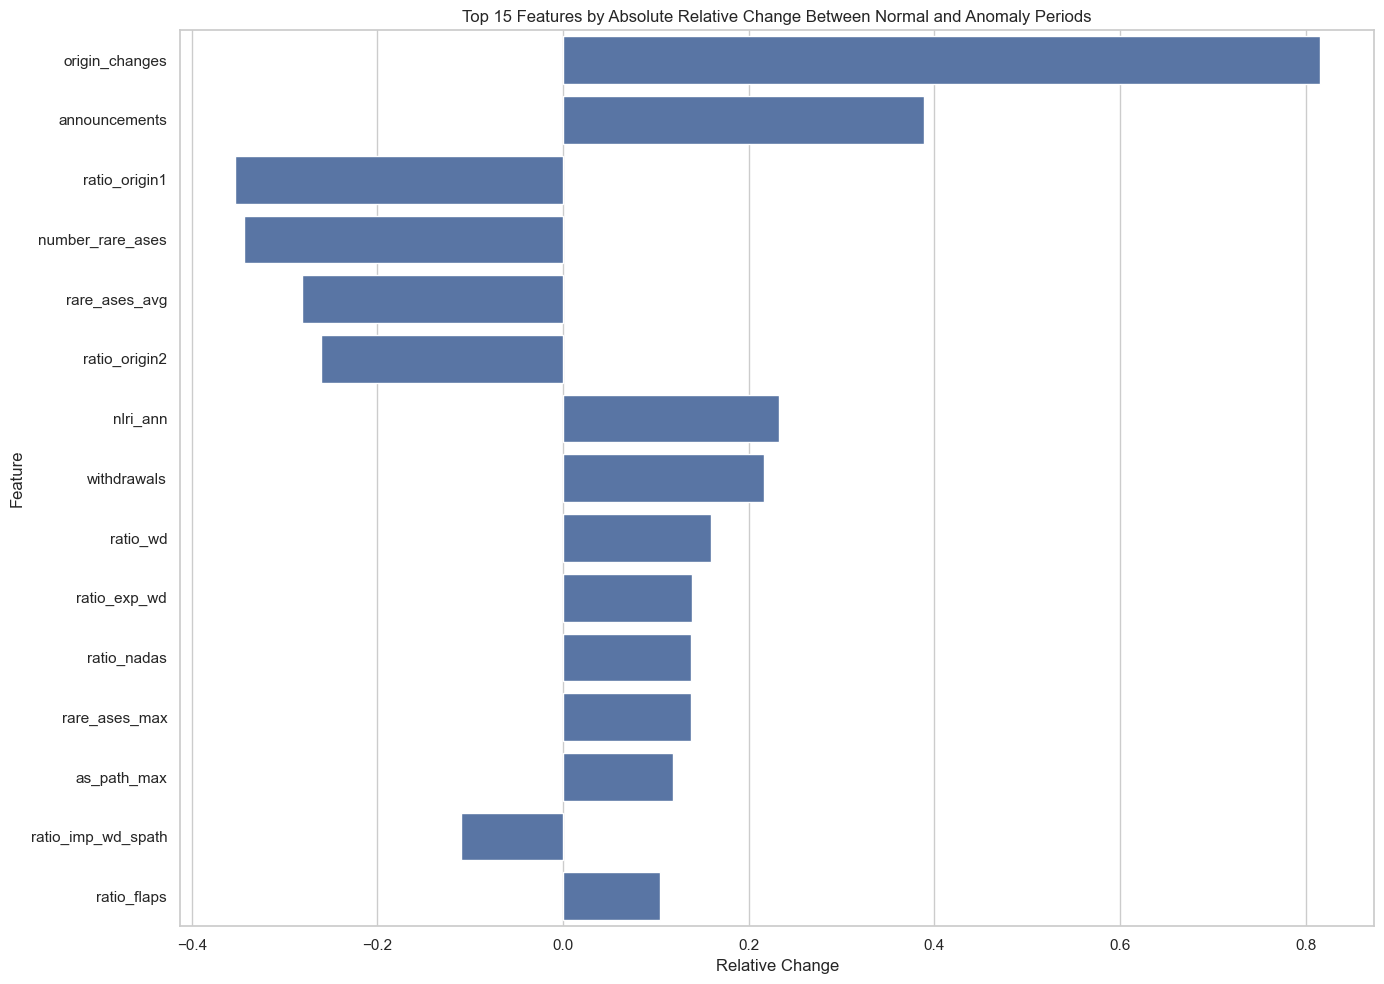

In [12]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [13]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X_selected = X[top_features]

Selected top features:
['origin_changes', 'announcements', 'ratio_origin1', 'number_rare_ases', 'rare_ases_avg', 'ratio_origin2', 'nlri_ann', 'withdrawals', 'ratio_wd', 'ratio_exp_wd', 'ratio_nadas', 'rare_ases_max', 'as_path_max', 'ratio_imp_wd_spath', 'ratio_flaps']


### 4. SVM Model Training and Hyperparameter Tuning

In [14]:
# Define training and test data
y_train = df["class"]
X_train = df.drop(["class"], axis=1)

# Test data
dataset_path = "../datasets/ratios/dataset_slammer_559_10_rrc04.csv"
df_test = pd.read_csv(dataset_path)
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)
y_test = df_test["class"]
X_test = df_test.drop(["class"], axis=1)

In [15]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [16]:
# Create a pipeline with preprocessing and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Define the hyperparameter search space
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:
{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV score: 0.9065


In [17]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

### 5. Model Evaluation with Advanced Metrics

In [18]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8193
Precision: 0.1667
Recall: 0.0442
F1 Score: 0.0699

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       623
           1       0.17      0.04      0.07       113

    accuracy                           0.82       736
   macro avg       0.51      0.50      0.48       736
weighted avg       0.74      0.82      0.77       736



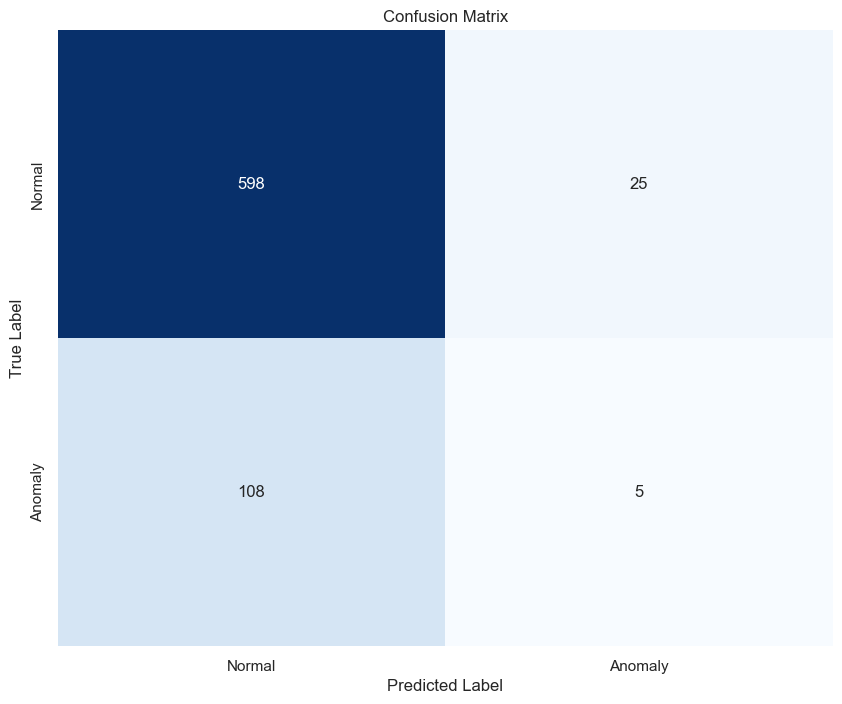

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

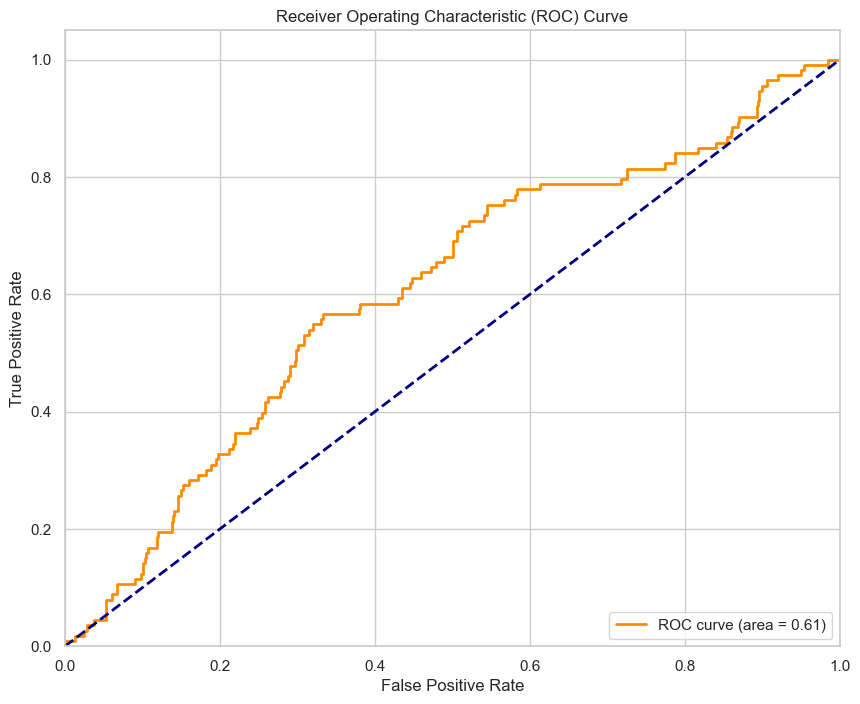

In [20]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

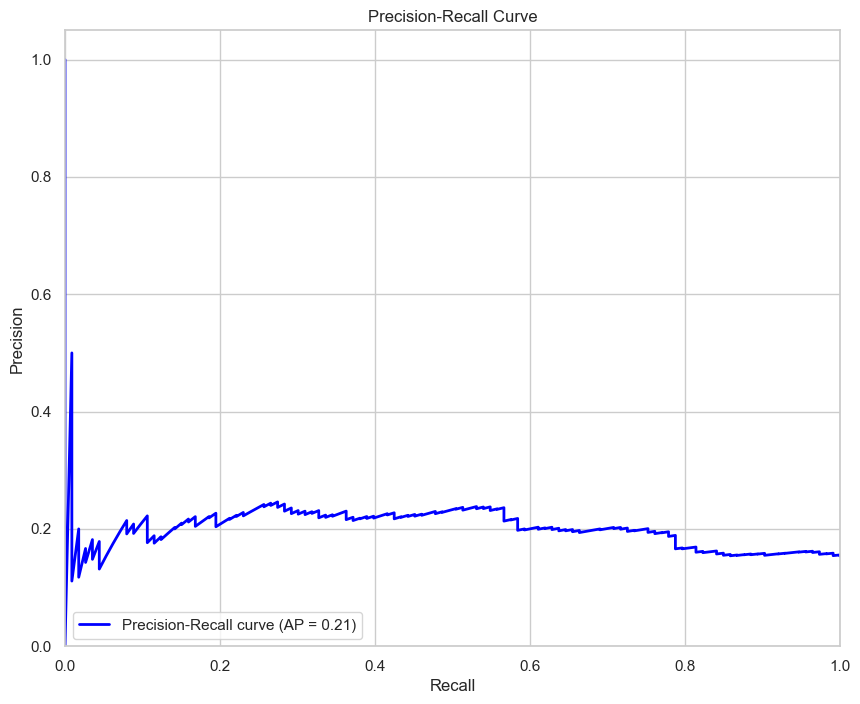

In [21]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### 6. Visualizing Decision Boundaries

Explained variance ratio: [0.18973666 0.13423511]
Total explained variance: 0.32


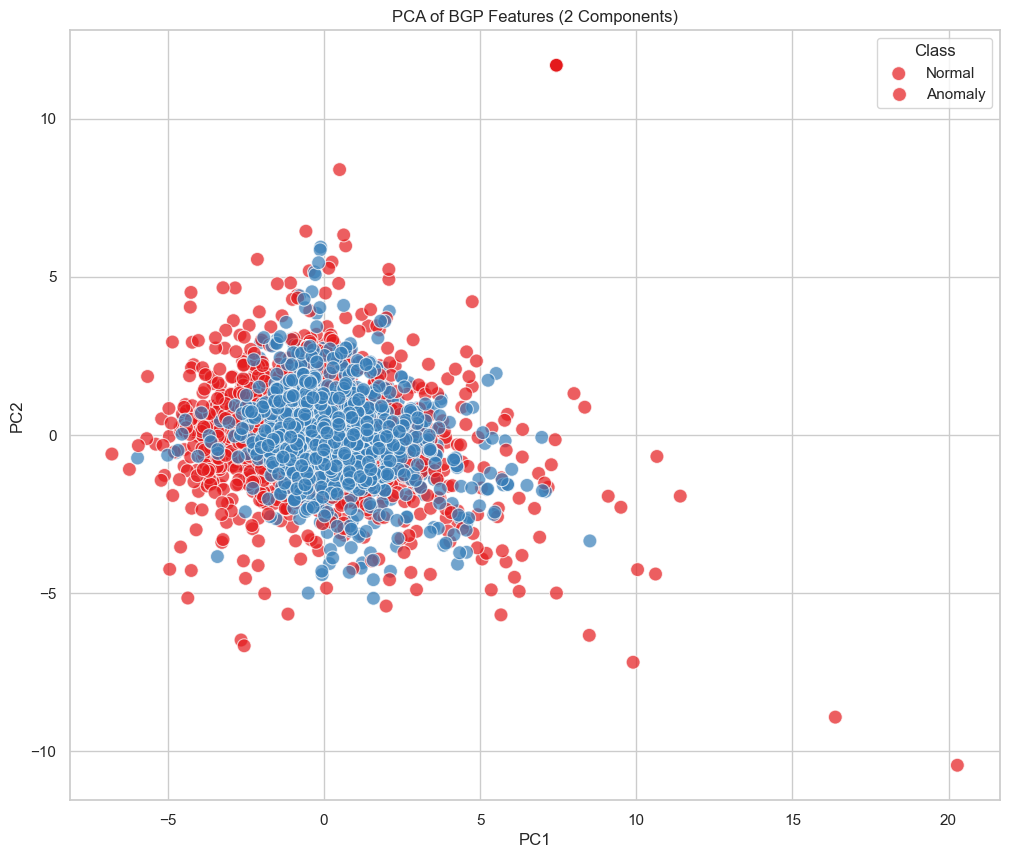

In [22]:
# Apply PCA to reduce to 2 dimensions for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_train.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

<Figure size 1400x1200 with 0 Axes>

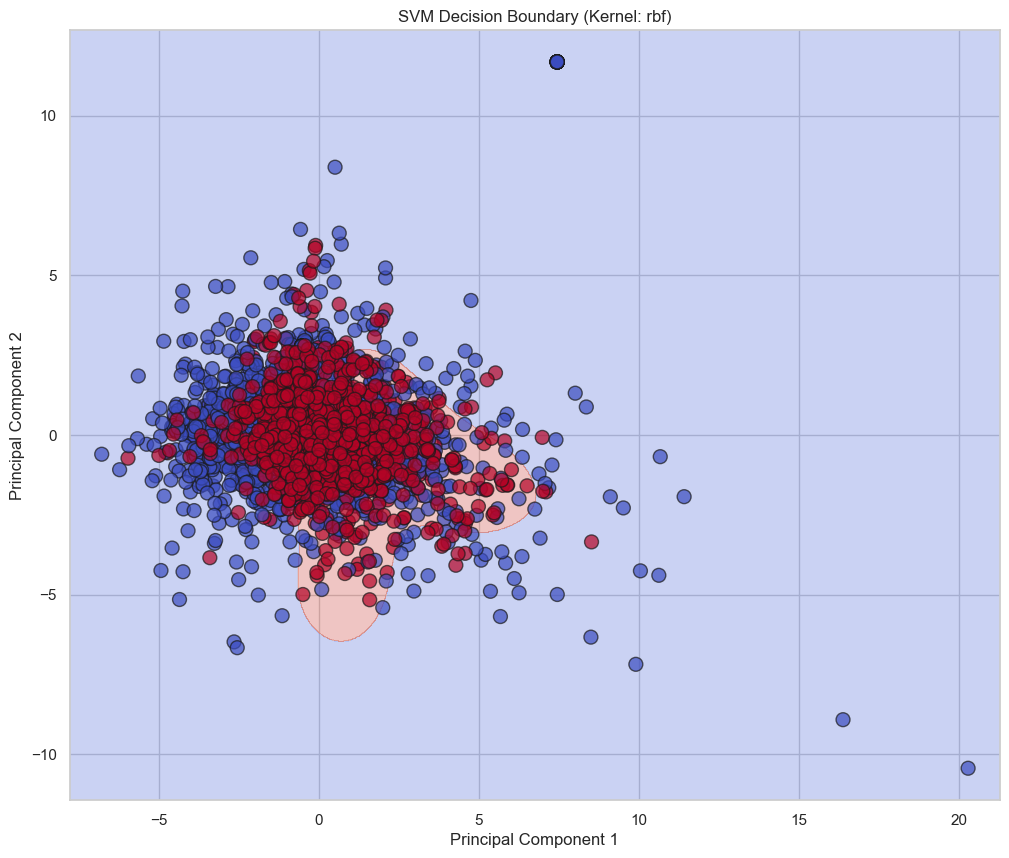

In [23]:
# Train an SVM on the PCA-transformed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_scaled)

X_train_pca = X_pca
y_train_pca = y_train

y_test_pca = y_test

# Use best parameters from grid search but adapt to the 2D case
best_params = grid_search.best_params_
svm_2d = SVC(
    C=best_params['svm__C'],
    gamma=best_params['svm__gamma'] if best_params['svm__gamma'] not in ['scale', 'auto'] else 'scale',
    kernel=best_params['svm__kernel'],
    probability=True
)
svm_2d.fit(X_train_pca, y_train_pca)

# Plot decision boundary
def plot_decision_boundary(X, y, model, ax=None):
    h = 0.02  # Step size in the mesh
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Get predictions for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    if ax is None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, alpha=0.7, edgecolors='k')
    return ax

plt.figure(figsize=(14, 12))
ax = plot_decision_boundary(X_pca, y_train.values, svm_2d)
plt.title(f'SVM Decision Boundary (Kernel: {best_params["svm__kernel"]})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

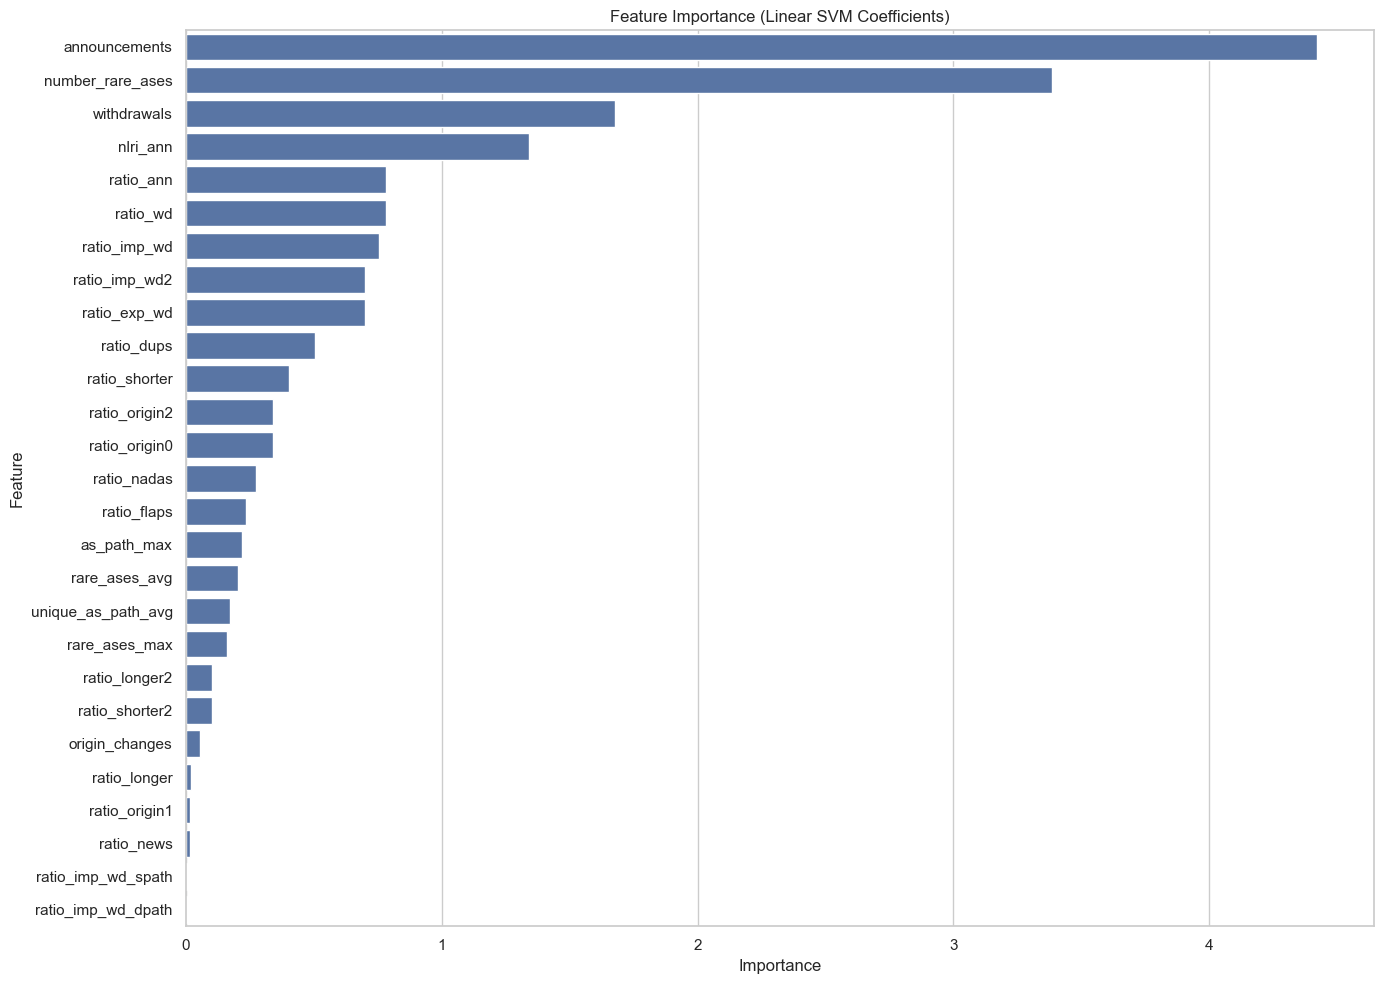

In [24]:
# Create and train a linear SVM for feature importance analysis
linear_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
linear_svm.fit(X_train, y_train)

# Extract feature importance scores (coefficients)
importances = abs(linear_svm.named_steps['svm'].coef_[0])
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Linear SVM Coefficients)')
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

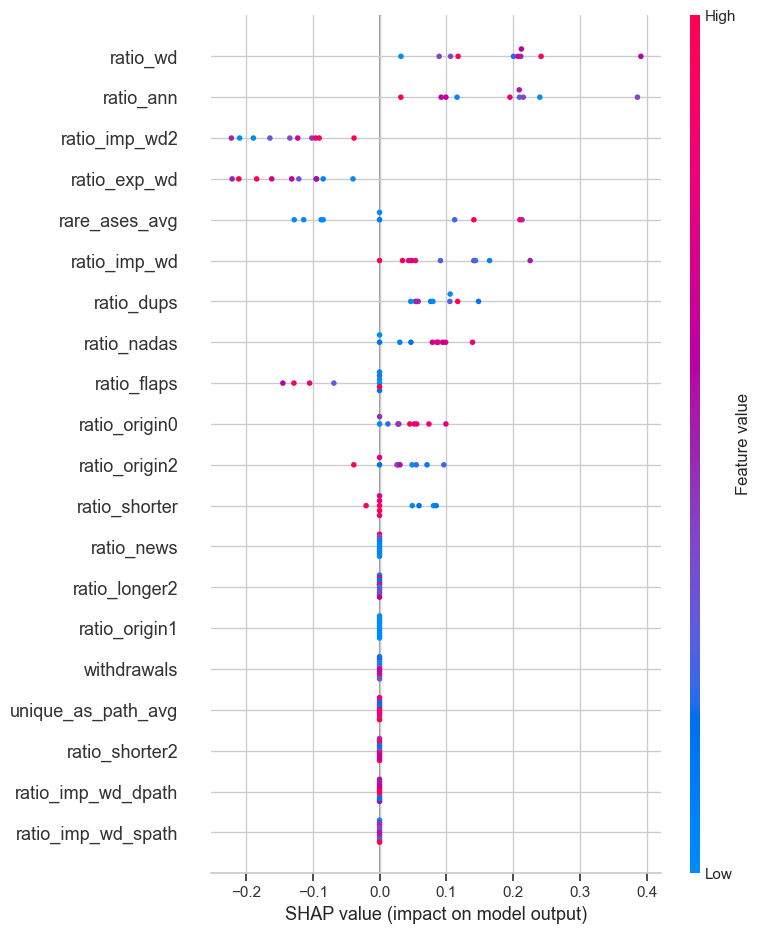

<Figure size 1200x800 with 0 Axes>

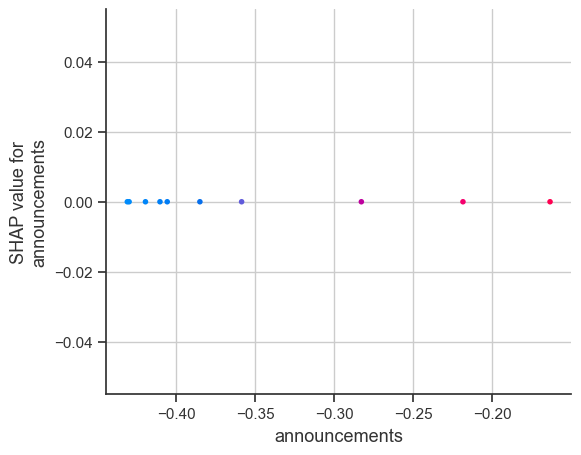

In [25]:
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_train.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_train.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")

Intercept 0.1492930881732319
Prediction_local [0.05232915]
Right: 0.03507945145363241


<Figure size 1200x600 with 0 Axes>

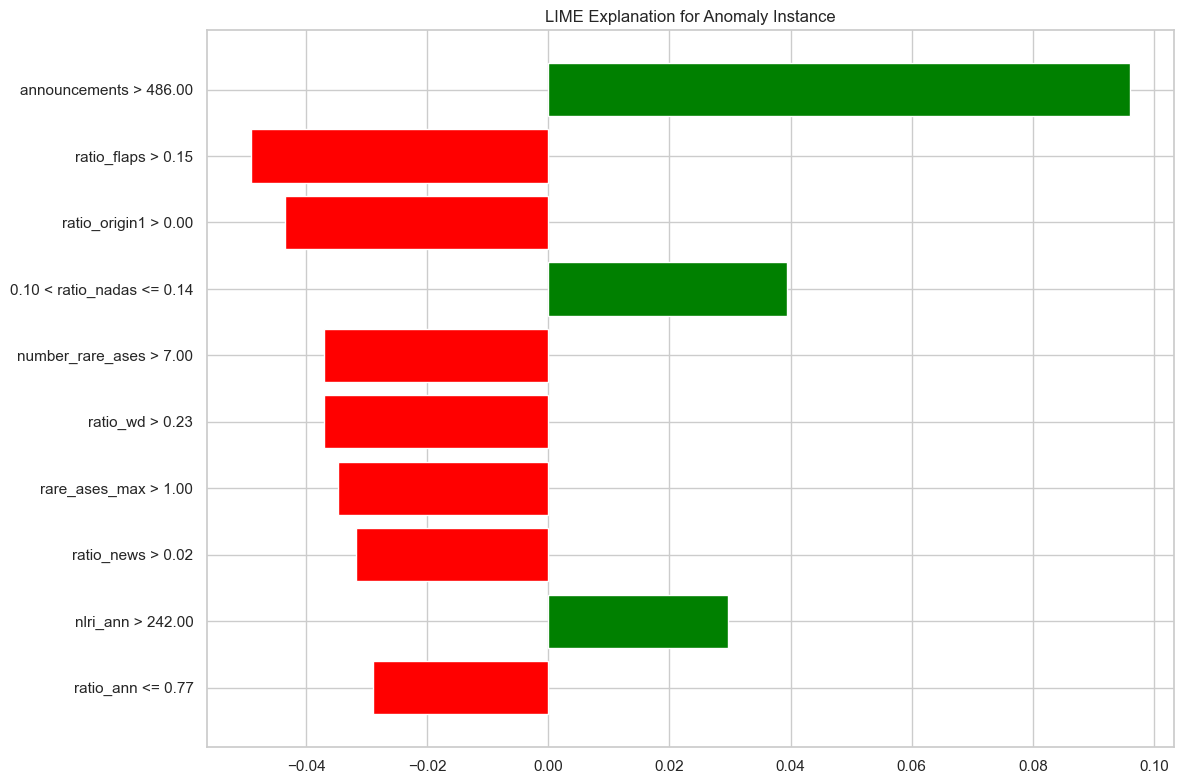

In [26]:
if EXPLAINABILITY_AVAILABLE:
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['Normal', 'Anomaly'],
        verbose=True,
        mode='classification'
    )
    
    # Find an anomaly instance to explain
    anomaly_indices = np.where(y_test == 1)[0]
    if len(anomaly_indices) > 0:
        # Pick an anomaly in the test set
        anomaly_idx = anomaly_indices[0]
        anomaly_instance = X_test.iloc[anomaly_idx].values
        
        # Generate LIME explanation
        lime_exp = lime_explainer.explain_instance(
            anomaly_instance, 
            best_model.predict_proba,
            num_features=10
        )
        
        # Plot the explanation
        plt.figure(figsize=(12, 6))
        lime_exp.as_pyplot_figure()
        plt.title("LIME Explanation for Anomaly Instance")
        plt.tight_layout()
        plt.show()
    else:
        print("No anomalies found in test set")
else:
    print("LIME analysis skipped because libraries are not installed.")